# Using the Progress Listeners with CPLEX Optimizer

This tutorial includes everything you need to set up decision optimization engines, build a mathematical programming model, then use the progress listeners to monitor progress, capture intermediate solutions and stop the solve on your own criteria.


When you finish this tutorial, you'll have a foundational knowledge of _Prescriptive Analytics_.

>This notebook is part of **[Prescriptive Analytics for Python](http://ibmdecisionoptimization.github.io/docplex-doc/)**
>
>It requires either an [installation of CPLEX Optimizers](http://ibmdecisionoptimization.github.io/docplex-doc/getting_started.html) or it can be run on [IBM Cloud Pak for Data as a Service](https://www.ibm.com/products/cloud-pak-for-data/as-a-service/) (Sign up for a [free IBM Cloud account](https://dataplatform.cloud.ibm.com/registration/stepone?context=wdp&apps=all>)
and you can start using `IBM Cloud Pak for Data as a Service` right away).
>
> CPLEX is available on <i>IBM Cloud Pack for Data</i> and <i>IBM Cloud Pak for Data as a Service</i>:
>    - <i>IBM Cloud Pak for Data as a Service</i>: Depends on the runtime used:
>         - <i>Python 3.x</i> runtime: Community edition
>         - <i>Python 3.x + DO</i> runtime: full edition
>    - <i>Cloud Pack for Data</i>: Community edition is installed by default. Please install `DO` addon in `Watson Studio Premium` for the full edition


Table of contents:

-  [Describe the business problem](#Describe-the-business-problem:--Games-Scheduling-in-the-National-Football-League)
*  [How decision optimization (prescriptive analytics) can help](#How--decision-optimization-can-help)
*  [Use decision optimization](#Use-decision-optimization)
    *  [Step 1: Set up the prescriptive model](#Step-1:-Set-up-the-prescriptive-model)
    *  [Step 2: Monitoring CPLEX progress](#Step-2:-Monitoring-CPLEX-progress)
    *  [Step 3: Aborting the search with a custom progress listener](#Step-3:-Aborting-the-search-with-a-custom-progress-listener)
    *  [Variant: using matplotlib to plot a chart of gap vs. time](#Variant:-using-matplotlib-to-plot-a-chart-of-gap-vs.-time)
*  [Summary](#Summary)
****


## How  decision optimization can help

* Prescriptive analytics (decision optimization) technology recommends actions that are based on desired outcomes.  It takes into account specific scenarios, resources, and knowledge of past and current events. With this insight, your organization can make better decisions and have greater control of business outcomes.  

* Prescriptive analytics is the next step on the path to insight-based actions. It creates value through synergy with predictive analytics, which analyzes data to predict future outcomes.  

* Prescriptive analytics takes that insight to the next level by suggesting the optimal way to handle that future situation. Organizations that can act fast in dynamic conditions and make superior decisions in uncertain environments gain a strong competitive advantage.  
<br/>

<u>With prescriptive analytics, you can:</u> 

* Automate the complex decisions and trade-offs to better manage your limited resources.
* Take advantage of a future opportunity or mitigate a future risk.
* Proactively update recommendations based on changing events.
* Meet operational goals, increase customer loyalty, prevent threats and fraud, and optimize business processes.



## Use decision optimization

### Step 1: Set up the prescriptive model

We need a scalable MIP model in order to show how to leverage progress listeners in Docplex MP API. 

Progress listeners are designed to monitor the progress of complex MIP search in docplex MP, 
that is, linear programs with integer variables.

This model is easily scalable, and thus is appropriate to demonstrate  the progress listener API, but any other scalable MIP model would do.

In [1]:
from docplex.mp.model import Model

def build_hearts(r, **kwargs):
    # initialize the model
    mdl = Model('love_hearts_%d' % r, **kwargs)

    # the dictionary of decision variables, one variable
    # for each circle with i in (1 .. r) as the row and
    # j in (1 .. i) as the position within the row    
    idx = [(i, j) for i in range(1, r + 1) for j in range(1, i + 1)]
    a = mdl.binary_var_dict(idx, name=lambda ij: "a_%d_%d" % ij)

    # the constraints - enumerate all equilateral triangles
    # and prevent any such triangles being formed by keeping
    # the number of included circles at its vertexes below 3

    # for each row except the last
    for i in range(1, r):
        # for each position in this row
        for j in range(1, i + 1):
            # for each triangle of side length (k) with its upper vertex at
            # (i, j) and its sides parallel to those of the overall shape
            for k in range(1, r - i + 1):
                # the sets of 3 points at the same distances clockwise along the
                # sides of these triangles form k equilateral triangles
                for m in range(k):
                    u, v, w = (i + m, j), (i + k, j + m), (i + k - m, j + k - m)
                    mdl.add(a[u] + a[v] + a[w] <= 2)

    mdl.maximize(mdl.sum(a))
    return mdl

Let's try to build a small instance of the 'hearts' program and print its characteristics.

In [2]:
m5 = build_hearts(5)
m5.print_information()

Model: love_hearts_5
 - number of variables: 15
   - binary=15, integer=0, continuous=0
 - number of constraints: 35
   - linear=35
 - parameters: defaults
 - objective: maximize
 - problem type is: MILP


### Step 2: Monitoring CPLEX progress

MIP search can take some time for large (or complex) problems. Setting the `log_output=True` in a solve() lets
you display the CPLEX log, which provides a lot of information. In certain cases, you might want to take control of what happens at intermediate points in the search, and this is what listeners are designed for.

#### An introduction to progress listeners

Progress listeners are objects, sub-classes of the `docplex.mp.progress.ProgressListener` class. Once a listener has been attached to a model instance (using `Model.add_progress_listener`), it receives method calls from within the CPLEX MIP search. CPLEX code decides when listeners are called, and this baseline logic cannot be changed. 
However, progress listeners let you select certian types of events.

First, we have to import the `docplex.mp.progress` module, which contains everything about progress listeners.

In [3]:
from docplex.mp.progress import *


#### Monitoring MIP search progress

The simplest class of listener is the `TextProgressListener`, which prints a message on the stdout each time it is called. Let's see what this does on our small model.

In [4]:

# connect a listener to the model
m5.add_progress_listener(TextProgressListener())

#### Solve with Decision Optimization

If you're using a Community Edition of CPLEX runtimes, depending on the size of the problem, the solve stage may fail and will need a paying subscription or product installation.

Here, we solve with the ***clean_before_true*** flag set to True, as we want each solve to produce the same output. Without this flag, a second solve on the model would start from the first solve solution, and would not have the same output.

In [5]:
m5.solve(clean_before_solve=True);

  1+: Node=0 Left=1 Best Integer=7.0000, Best Bound=10.0000, gap=42.86%, ItCnt=21 [0.0s]
  2+: Node=0 Left=1 Best Integer=7.0000, Best Bound=9.3266, gap=33.24%, ItCnt=33 [0.0s]
  3+: Node=0 Left=1 Best Integer=7.0000, Best Bound=9.0636, gap=29.48%, ItCnt=42 [0.0s]
  4+: Node=0 Left=1 Best Integer=8.0000, Best Bound=9.0636, gap=13.29%, ItCnt=42 [0.0s]


The listener prints one line each time it is called by CPLEX code; fromthis we can see that:

   - the listener is called several time from the same node (0)
   - the listener is called several time at the same iteration (ItCnt=42)
   - the listener is called several times with the same objective 7.0
   
In each line, the '+' indicates that an intermediate solution is available at the time of the call. In this case, an intermediate solution was available at each call, but this is not always the case.
Looking closer, we also see that the listener reacts to events which improve either the objective or the best bound.
This is due to the value of the _clock_ attribute of the listener

#### Listener clocks

Clocks are value sof the enumerated type `docplex.mp.progress.ProgressClock`, which defines types of events to listen to. Every listener has a clock, the default being `ProgressClock.Gap`, which reacts when an event satisfies the following conditions:

   - an intermediate solution is available 
   - either the objective has improved _or_ the best bound has improved
    
Let's check this on our model:

In [6]:
for l, listener in enumerate(m5.iter_progress_listeners(), start=1):
    print("listener #{0} has type '{1}', clock={2}".format(l, listener.__class__.__name__, listener.clock))

listener #1 has type 'TextProgressListener', clock=ProgressClock.Gap


Now, let's experiment with a text progress listener listening to the `All` clock, that is the baseline clock that reacts to all calls from CPLEX. To do so, we first clear all progress listeners and add a new one.

Note the constructor also accepts strings, interpreted as clock name.

In [7]:
m5.clear_progress_listeners()
m5.add_progress_listener(TextProgressListener(clock='all'))
m5.solve(clean_before_solve=True);

  1+: Node=0 Left=1 Best Integer=7.0000, Best Bound=10.0000, gap=42.86%, ItCnt=21 [0.0s]
  2+: Node=0 Left=1 Best Integer=7.0000, Best Bound=10.0000, gap=42.86%, ItCnt=21 [0.0s]
  3+: Node=0 Left=1 Best Integer=7.0000, Best Bound=10.0000, gap=42.86%, ItCnt=33 [0.0s]
  4+: Node=0 Left=1 Best Integer=7.0000, Best Bound=9.3266, gap=33.24%, ItCnt=33 [0.0s]
  5+: Node=0 Left=1 Best Integer=7.0000, Best Bound=9.3266, gap=33.24%, ItCnt=42 [0.0s]
  6+: Node=0 Left=1 Best Integer=7.0000, Best Bound=9.0636, gap=29.48%, ItCnt=42 [0.0s]
  7+: Node=0 Left=1 Best Integer=8.0000, Best Bound=9.0636, gap=13.29%, ItCnt=42 [0.0s]
  8+: Node=0 Left=1 Best Integer=8.0000, Best Bound=9.0636, gap=13.29%, ItCnt=45 [0.0s]


In this case, the listener is called more often, sometimes with identical objective and bound (see lines 3 and 4). This explains why the default clock is __Gap__ , to focus on actual changes.

Other possible values for the clock enumerated type are:

   - __Solutions__: listen to all intermediate solutions, whether or not they improve objective or best bound.
   - __Objective__: listen to intermediate solutions, which improve the objective.
   
How exactly is improvement measured? A listener constructor can specify an _absdiff_ and _reldiff_ parameters which ar e interpreted as the minimal absolute (resp. relative) improvement to accept or not a call from CPLEX.

Let us demonstrate this with a third `TextProgressListener` with clock set to 'objective' and an absolute diff of 1. We expect this listener to react whenever th eobjec5tive ha simprobed by an amount greater than 1:

In [8]:
m5.clear_progress_listeners()
m5.add_progress_listener(TextProgressListener(clock='objective', absdiff=1, reldiff=0))
m5.solve(clean_before_solve=True);

  1+: Node=0 Left=1 Best Integer=7.0000, Best Bound=10.0000, gap=42.86%, ItCnt=21 [0.0s]
  2+: Node=0 Left=1 Best Integer=8.0000, Best Bound=9.0636, gap=13.29%, ItCnt=42 [0.0s]


As expected, the listener accepted three events, with the objective vaklues of 6,7 and 8.

#### Monitor progress: manage intermediate solutions

This is done by another predefined listener class: `SolutionRecorder`. This type of listener is a subclass of the `SolutionListerer` class. Again, this listener contains a _clock_ parameter (default is __Gap__) which controls which events are accepted or not.

The default behavior is to accept only solutions, which improve either the objective or the best bound

In [9]:
from docplex.mp.progress import SolutionRecorder

sol_recorder = SolutionRecorder()
m5.clear_progress_listeners()
m5.add_progress_listener(sol_recorder)

Again, we solve with the `clean_before_solve` flag set to `True` to ensure a deterministic behavior.

In [10]:
m5.solve(clean_before_solve=True);

At the end of the solve, the recorder contains all the intermediate solutions.
Now, let's display some information about those intermediate solutions.

In [11]:
# utility function to display recorded solutions in a recorder.
def display_recorded_solutions(rec):
    print('* The recorder contains {} solutions'.format(rec.number_of_solutions))
    for s, sol in enumerate(rec.iter_solutions(), start=1):
        sumvals = sum(v for _, v in sol.iter_var_values())
        print('  - solution #{0}, obj={1}, non-zero-values={2}, total={3}'.format(
           s, sol.objective_value, sol.number_of_var_values, sumvals))
        
display_recorded_solutions(sol_recorder)

* The recorder contains 4 solutions
  - solution #1, obj=7.0, non-zero-values=15, total=7.0
  - solution #2, obj=7.0, non-zero-values=15, total=7.0
  - solution #3, obj=7.0, non-zero-values=15, total=7.0
  - solution #4, obj=8.0, non-zero-values=15, total=8.0


Now, let's try a solution recorder with a different clock: __Objective__. This recorder will record only intermediate solutions which improve the objective, regardless of the best bound. Such changes occur less frequently than the Gap clock, so we expect less solutions to be recorded.

In [12]:
sol_recorder2 = SolutionRecorder(clock='objective')
m5.clear_progress_listeners()
m5.add_progress_listener(sol_recorder2)
m5.solve(clean_before_solve=True)
display_recorded_solutions(sol_recorder2)

* The recorder contains 2 solutions
  - solution #1, obj=7.0, non-zero-values=15, total=7.0
  - solution #2, obj=8.0, non-zero-values=15, total=8.0


As expected, the 'objective' recorder stored only 3 solutions instead of 5. Only one solution with objective 7 is recorded, instead of three with the 'Gap' recorder.

### Step 3: Aborting the search with a custom progress listener

MIP search can be time-consuming; insome cases, a 'good-enough' solution can be sufficient.
For example, when the gap is converging very slowly, it may be a good idea to stop and use the last solution instead of waiting for along time to prove optimality.

Let's assume we want to implement the following behavior: 
stop the search, when no improvement has occured in objective for N seconds since the latest improvements.

The first question to ask is: what clock do we listen to? As we want to stop as soon as 
elapsed time without improvement is greater than our limit, we listent to the higher frequency clock, `All` clock.

Second, as we do not care for solutions, we sub-class from `ProgressListener`, not from `SolutionListener`.

What do we need to code this aborter? we need to know whether an incumbent solution is present, and what is its objective value, then check whether the objective has improved or not.
If it has improved, we store the value of the objective and the time (obtained throught `ProgressData.time`),
if not, we check whether elapsed time is greater than the limit, and if it is the case, call method `abort()`.

The code is as follows:

In [13]:
from docplex.mp.progress import ProgressListener

class AutomaticAborter(ProgressListener):
    """ a simple implementation of an automatic search stopper.
    """
    def __init__(self, max_no_improve_time=10.):
        super(AutomaticAborter, self).__init__(ProgressClock.All)
        self.last_obj = None
        self.last_obj_time = None
        self.max_no_improve_time = max_no_improve_time
        
    def notify_start(self):
        super(AutomaticAborter, self).notify_start()
        self.last_obj = None
        self.last_obj_time = None    
        
    def is_improving(self, new_obj, eps=1e-4):
        last_obj = self.last_obj
        return last_obj is None or (abs(new_obj- last_obj) >= eps)
            
    def notify_progress(self, pdata):
        super(AutomaticAborter, self).notify_progress(pdata)
        if pdata.has_incumbent and self.is_improving(pdata.current_objective):
            self.last_obj = pdata.current_objective
            self.last_obj_time = pdata.time
            print('----> #new objective={0}, time={1}s'.format(self.last_obj, self.last_obj_time))
        else:
            # a non improving move
            last_obj_time = self.last_obj_time
            this_time = pdata.time
            if last_obj_time is not None:
                elapsed = (this_time - last_obj_time)
                if elapsed >= self.max_no_improve_time:
                    print('!! aborting cplex, elapsed={0} >= max_no_improve: {1}'.format(elapsed,
                                                                             self.max_no_improve_time))
                    self.abort()
                else:
                    print('----> non improving time={0}s'.format(elapsed))

We demonstrate the aborter on a bigger problem:

In [14]:
large_hearts = build_hearts(12)
#large_hearts.add_progress_listener(TextProgressListener(clock='gap'))
# maximum non-improving time is 4 seconds.
large_hearts.add_progress_listener(AutomaticAborter(max_no_improve_time=4))
# again use clean_before_solve to ensure deterministic run of this cell.
large_hearts.solve(clean_before_solve=True, log_output=False);

----> #new objective=23.0, time=0.015999999945051968s
----> non improving time=0.0s
----> non improving time=0.03100000007543713s
----> non improving time=0.03100000007543713s
----> non improving time=0.03100000007543713s
----> non improving time=0.03100000007543713s
----> non improving time=0.0470000000204891s
----> non improving time=0.0470000000204891s
----> non improving time=0.07800000009592623s
----> non improving time=0.07800000009592623s
----> non improving time=0.0940000000409782s
----> non improving time=0.0940000000409782s
----> non improving time=0.10900000005494803s
----> non improving time=0.10900000005494803s
----> #new objective=24.0, time=0.1559999999590218s
----> non improving time=0.0s
----> non improving time=0.0470000000204891s
----> non improving time=0.0470000000204891s
----> non improving time=0.1410000000614673s
----> non improving time=0.15700000000651926s
----> non improving time=0.15700000000651926s
----> non improving time=0.15700000000651926s
----> non imp

Though the solve has been aborted, it returned the latest solution,
but the status of the solve shows it hhas been aborted.

In [15]:
large_s = large_hearts.solution
print('* solution has objective {0}'.format(large_s.objective_value))
print("* solve status is '{}'".format(large_hearts.solve_details.status))

* solution has objective 24.0
* solve status is 'aborted'


In [16]:
class MipGapPrinter(ProgressListener):
  
    def __init__(self):
        ProgressListener.__init__(self, ProgressClock.Gap)
    
    def notify_progress(self, pdata):
        gap = pdata.mip_gap
        ms_time = 1000* pdata.time
        print('-- new gap: {0:.1%}, time: {1:.0f} ms'.format(gap, ms_time))

In [17]:
m8 = build_hearts(8)
m8.add_progress_listener(MipGapPrinter())
m8.solve(clean_before_solve=True);

-- new gap: 71.4%, time: 15 ms
-- new gap: 65.9%, time: 15 ms
-- new gap: 62.0%, time: 15 ms
-- new gap: 60.6%, time: 15 ms
-- new gap: 59.5%, time: 31 ms
-- new gap: 58.6%, time: 46 ms
-- new gap: 57.8%, time: 46 ms
-- new gap: 57.1%, time: 78 ms
-- new gap: 56.2%, time: 78 ms
-- new gap: 55.4%, time: 93 ms


### Variant: using matplotlib to plot a chart of gap vs. time

In this variant, we use `matplotlib` to chart the evolution of gap over time. The logic of the custom listener is exactly similar to the gap printer, except that we call matplotlib.plot instead of printing a message.

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline


In [19]:
from docplex.mp.progress import ProgressListener, ProgressClock
from IPython import display

class MipGapPlotter(ProgressListener):
    
    def __init__(self):
        ProgressListener.__init__(self, ProgressClock.Gap)
        plt.ion()
        self.fig = plt.figure(figsize=(10,4))
        self.ax = self.fig.add_subplot(1,1,1)
    
    def notify_start(self):
        self.times =[]
        self.gaps = []
        #self.lines, = ax.plot([],[], 'o')
        plt.xlabel('time (ms)')
        plt.ylabel('gap (%)')
        
    def notify_progress(self, pdata):
        gap = pdata.mip_gap
        time = pdata.time
        self.times.append(1000* time)
        self.gaps.append(100*gap)
        plt.plot(self.times, self.gaps, 'go-')
        display.display(plt.gcf())
        display.clear_output(wait=True)


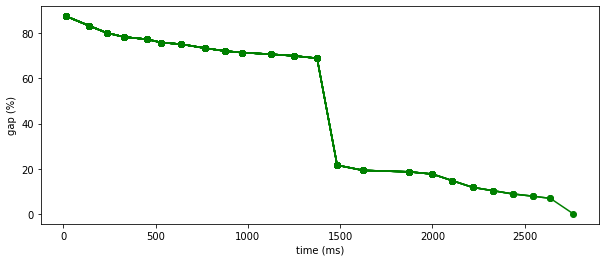

In [20]:
m9 = build_hearts(9)
m9.add_progress_listener(MipGapPlotter())
m9.solve(clean_before_solve=True);

## Summary


You learned how to set up and use the IBM Decision Optimization CPLEX Modeling for Python to formulate a Mathematical Programming model and track its progress.

#### References
* [Decision Optimization CPLEX Modeling for Python documentation](http://ibmdecisionoptimization.github.io/docplex-doc/)
* [IBM Decision Optimization](https://www.ibm.com/analytics/decision-optimization)
* Need help with DOcplex or to report a bug? Please go [here](https://stackoverflow.com/questions/tagged/docplex)
* Contact us at dofeedback@wwpdl.vnet.ibm.com"


Copyright &copy; 2017-2022 IBM. Sample Materials.